In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np


C:\Users\winuser\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
boston_housing = keras.datasets.boston_housing
(train_data,train_labels),(test_data,test_labels)=boston_housing.load_data()

#shuffling the training set
order = np.argsort(np.random.random(train_labels.shape))

train_data=train_data[order]
train_labels=train_labels[order]

In [4]:
print("Training set: {}".format(train_data.shape))
print('Testing set: {}'.format(test_data.shape))


Training set: (404, 13)
Testing set: (102, 13)


In [5]:
print(train_data[0])

[7.8750e-02 4.5000e+01 3.4400e+00 0.0000e+00 4.3700e-01 6.7820e+00
 4.1100e+01 3.7886e+00 5.0000e+00 3.9800e+02 1.5200e+01 3.9387e+02
 6.6800e+00]


In [6]:
import pandas as pd

In [7]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']
df=pd.DataFrame(train_data,columns=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.07875,45.0,3.44,0.0,0.437,6.782,41.1,3.7886,5.0,398.0,15.2,393.87,6.68
1,4.55587,0.0,18.10,0.0,0.718,3.561,87.9,1.6132,24.0,666.0,20.2,354.70,7.12
2,0.09604,40.0,6.41,0.0,0.447,6.854,42.8,4.2673,4.0,254.0,17.6,396.90,2.98
3,0.01870,85.0,4.15,0.0,0.429,6.516,27.7,8.5353,4.0,351.0,17.9,392.43,6.36
4,0.52693,0.0,6.20,0.0,0.504,8.725,83.0,2.8944,8.0,307.0,17.4,382.00,4.63


In [8]:
print(train_labels[0:10])

[32.  27.5 32.  23.1 50.  20.6 22.6 36.2 21.8 19.5]


In [9]:
# Normalize features

mean=train_data.mean(axis=0)
std=train_data.std(axis=0)
train_data=(train_data-mean)/std
test_data=(test_data-mean)/std
print(train_data[0])

[-0.39725269  1.41205707 -1.12664623 -0.25683275 -1.027385    0.72635358
 -1.00016413  0.02383449 -0.51114231 -0.04753316 -1.49067405  0.41584124
 -0.83648691]


## Create the model

In [10]:
'''
Let's build our model. Here, we'll use a Sequential model with two densely connected hidden layers, 
and an output layer that returns a single, continuous value.
The model building steps are wrapped in a function, build_model, 
since we'll create a second model, later on.
'''

def build_model():
    model=keras.Sequential([
        keras.layers.Dense(64,activation=tf.nn.relu,
                          input_shape=(train_data.shape[1],)),
        keras.layers.Dense(64,activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])
    optimizer = tf.train.RMSPropOptimizer(0.001)
    
    model.compile(loss='mse',
                  optimizer=optimizer,
                 metrics=['mae'])
    return model

model=build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


## Train the model


In [12]:
# DIsplay Training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        if epoch % 100 == 0: print( '')
        print('.',end='')
            
EPOCHS=500

# Store training stats
history = model.fit(train_data,train_labels,epochs=EPOCHS,
                   validation_split=0.2,verbose=0,
                   callbacks=[PrintDot()])
 


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

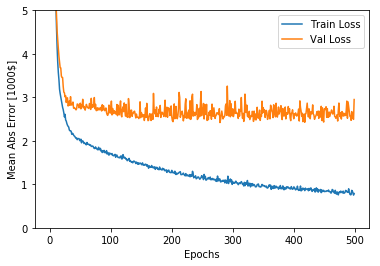

In [14]:
'''
Visualize the model's training progress using the stats stored in the history object.
We want to use this data to determine 
how long to train before the model stops making progress.
'''
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure()
    plt.xlabel("Epochs")
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch,np.array(history.history['mean_absolute_error']),
            label='Train Loss')
    plt.plot(history.epoch,np.array(history.history['val_mean_absolute_error']),
                                   label='Val Loss')
    plt.legend()
    plt.ylim([0,5])

plot_history(history)


....................................................................................................
........................................

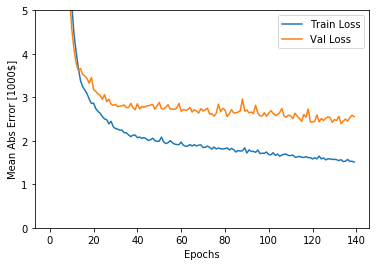

In [15]:
'''
This graph shows little improvement in the model after about 200 epochs. 
Let's update the model.fit method to automatically stop training when the validation score doesn't improve.
We'll use a callback that tests a training condition for every epoch. 
If a set amount of epochs elapses without showing improvement,
then automatically stop the training

'''
model=build_model()

#The patience parameter is the amount of epochs to check for improvement.

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)

history = model.fit(train_data,train_labels,epochs=EPOCHS,validation_split=0.2,verbose=0,callbacks=[early_stop,PrintDot()])

plot_history(history)

In [16]:
[loss,mae] =model.evaluate(test_data,test_labels,verbose=0)
print("Testing set Mean Abs Error : ${:7.2f}".format(mae*1000))

Testing set Mean Abs Error : $2602.50


In [17]:
test_predictions = model.predict(test_data).flatten()
print(test_predictions)

[ 8.49926  19.108952 21.666262 34.628857 26.515728 21.30618  26.566723
 22.20325  19.990017 22.027744 17.44492  16.872814 16.162722 43.395493
 19.609177 20.457092 26.620708 19.432684 18.61126  26.496809 10.566347
 14.336576 21.614004 16.7734   20.440922 24.722042 30.597954 30.653149
 10.365055 20.25386  20.519978 14.69973  35.64663  24.920076 18.191273
  8.484942 16.389898 18.84438  21.145966 26.00443  31.395008 29.308308
 13.90147  42.413963 32.074608 26.441696 28.703804 17.628952 22.9684
 23.382008 35.243862 20.237263 11.071134 15.953012 37.042397 28.604015
 12.545449 51.63192  37.76371  24.471903 24.369297 16.981459 13.863323
 19.229025 24.301144 22.157944 13.808052 23.05524  12.839354  7.651726
 25.640287 30.225227 25.855488 13.601938 25.753906 19.564537 19.51152
 24.32158  37.24631  10.722332 21.726442 39.998764 15.988519 13.935528
 17.92992  20.369217 20.463943 20.929272 20.765038 31.389687 21.77644
 19.259659 25.8411   42.227074 38.31504  20.617783 37.07784  48.748306
 26.56128 